In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Mounted at /content/gdrive
/content/gdrive/My Drive/Pytorch-Models


In [ ]:
!pip install mediapipe

In [15]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow  # Only needed in Colab

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [9]:
def draw_smooth_pose(image, landmarks, connections,
                     point_color=(255,165,0), line_color=(0,255,255), thickness=2):
    """Draw pose landmarks with anti-aliased lines."""
    h, w, _ = image.shape

    # Draw lines first
    for conn in connections:
        start = landmarks.landmark[conn[0]]
        end = landmarks.landmark[conn[1]]
        if start.visibility > 0.5 and end.visibility > 0.5:
            p1 = (int(start.x * w), int(start.y * h))
            p2 = (int(end.x * w), int(end.y * h))
            cv2.line(image, p1, p2, line_color, thickness, cv2.LINE_AA)

    # Draw points on top
    for lm in landmarks.landmark:
        if lm.visibility > 0.5:
            center = (int(lm.x * w), int(lm.y * h))
            cv2.circle(image, center, 3, point_color, -1, cv2.LINE_AA)

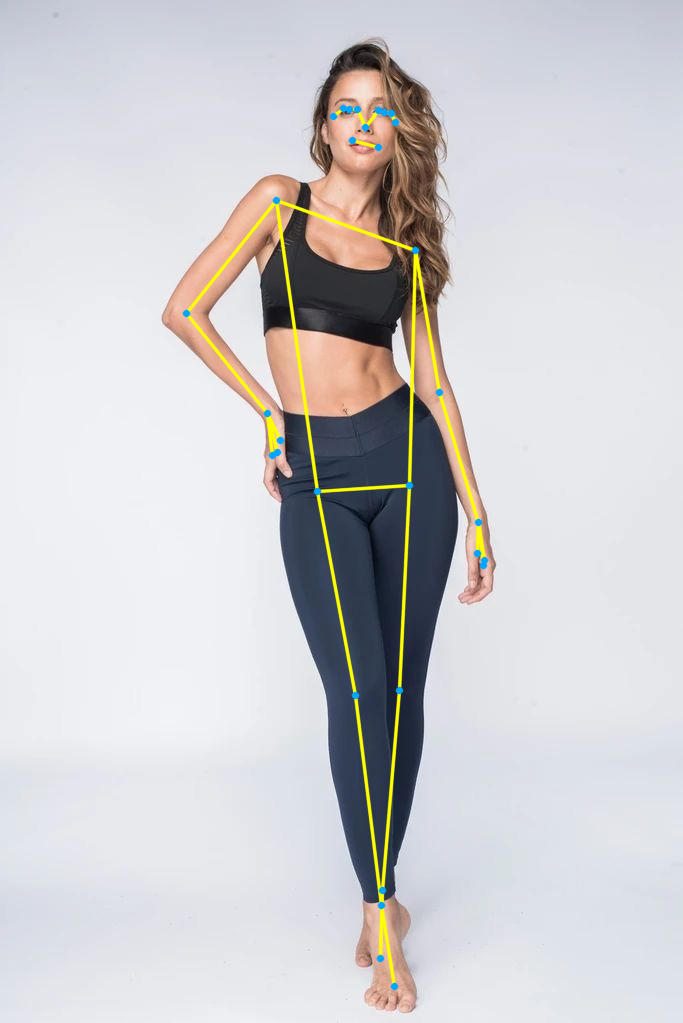

In [10]:
# Example: load some test images
pose_images = {
    "person1": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (7).jpg"),
    #"person2": cv2.imread("/content/person2.jpg"),
}

with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,          # 0=fastest, 2=most accurate
    enable_segmentation=False,   # True if you want segmentation mask
    min_detection_confidence=0.1
) as pose:
    for name, image in pose_images.items():
        if image is None:
            print(f"Error loading image: {name}. Please check the file path.")
            continue

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.pose_landmarks:
            print(f"No pose landmarks detected in {name}")
            continue

        annotated_image = image.copy()
        # mp_drawing.draw_landmarks(
        #     annotated_image,
        #     results.pose_landmarks,
        #     mp_pose.POSE_CONNECTIONS,
        #     mp_drawing.DrawingSpec(color=(255, 165, 0), thickness=2, circle_radius=1),   # points
        #     mp_drawing.DrawingSpec(color=(0,255,255), thickness=2)                   # lines
        # )
        draw_smooth_pose(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            point_color=(255,165,0),
            line_color=(0,255,255),
            thickness=2
        )
        cv2_imshow(annotated_image)

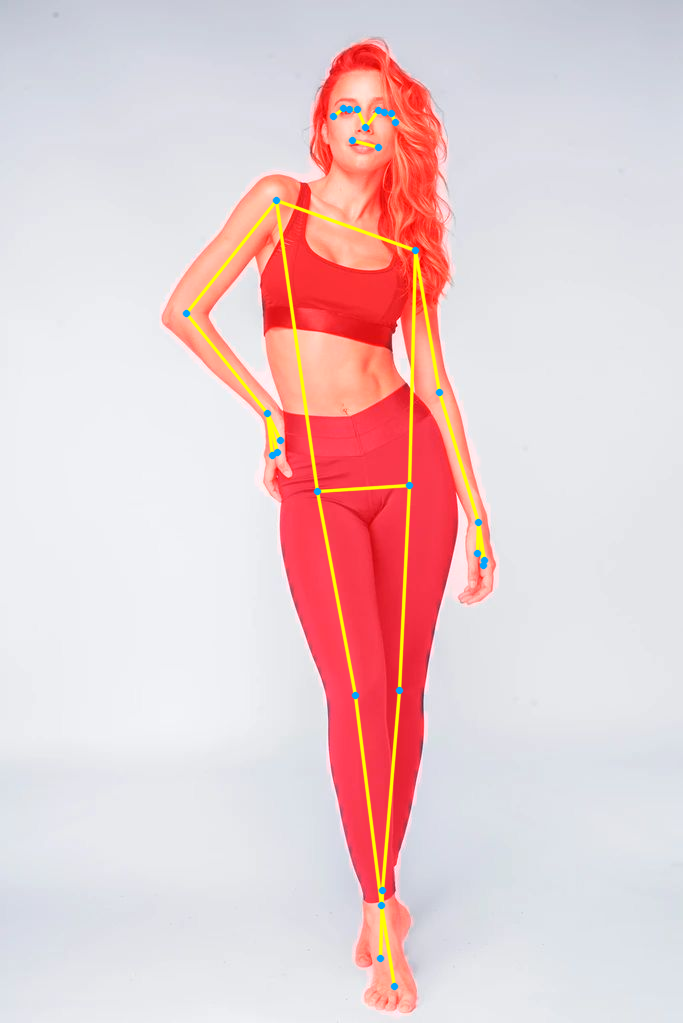

In [13]:
import numpy as np

pose_images = {
    "person1": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (7).jpg"),
}

with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,    # segmentation enabled
    min_detection_confidence=0.1
) as pose:
    for name, image in pose_images.items():
        if image is None:
            print(f"Error loading image: {name}. Please check the file path.")
            continue

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.pose_landmarks:
            print(f"No pose landmarks detected in {name}")
            continue

        annotated_image = image.copy()

        # --- Segmentation mask overlay ---
        if results.segmentation_mask is not None:
            mask = results.segmentation_mask
            # Convert to 3-channel for coloring
            mask_3ch = np.stack((mask,)*3, axis=-1)

            # Person area color (red here)
            fg_color = np.array([0, 0, 255], dtype=np.uint8)
            # Background color (transparent or dimmed)
            bg_color = np.array([0, 0, 0], dtype=np.uint8)

            # Create overlay image
            overlay = (mask_3ch * fg_color + (1 - mask_3ch) * bg_color).astype(np.uint8)

            # Blend overlay with original image
            annotated_image = cv2.addWeighted(annotated_image, 1.0, overlay, 0.8, 0)

        # --- Pose drawing ---
        draw_smooth_pose(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            point_color=(255,165,0),
            line_color=(0,255,255),
            thickness=2
        )

        cv2_imshow(annotated_image)

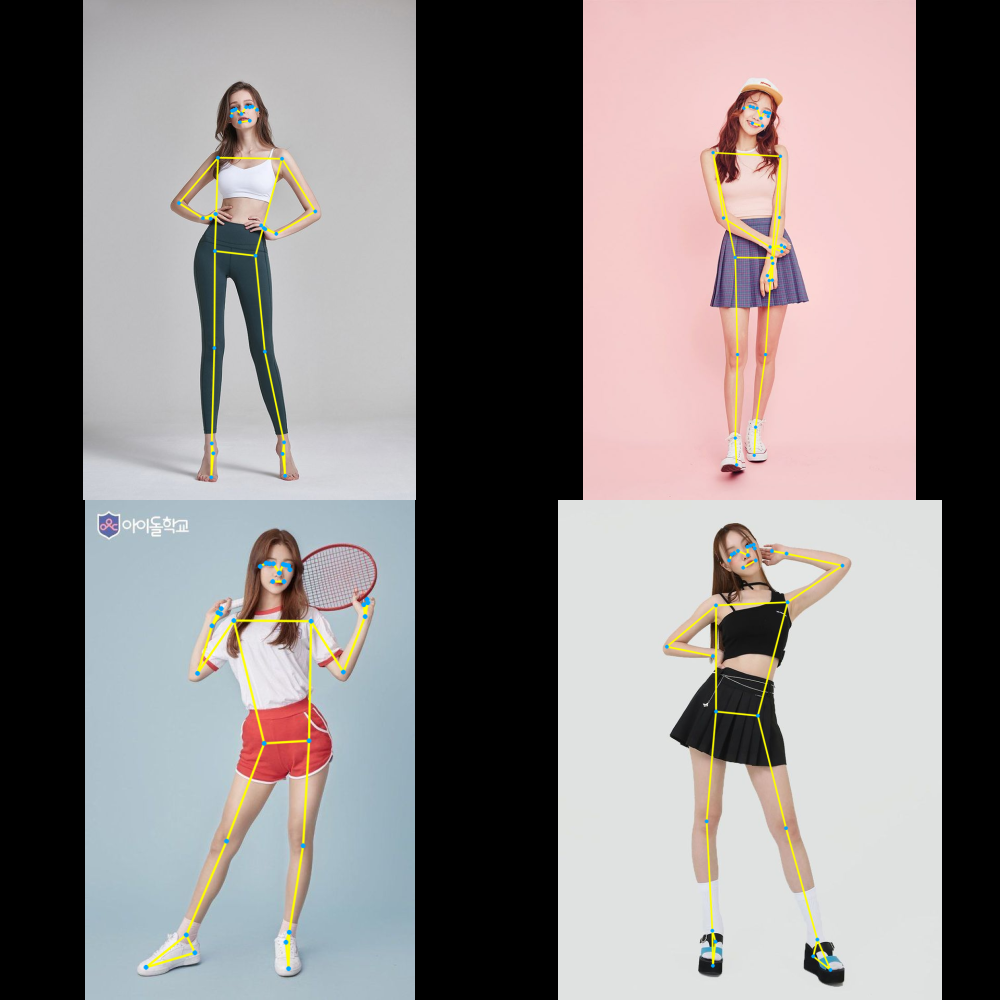

In [22]:
# Example: load some test images
pose_images = {
    "person1": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (16).jpg"),
    "person2": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (9).jpg"),
    "person3": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (15).jpg"),
    "person4": cv2.imread("/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (6).jpg"),
}

# Store results for grid display
processed_images = []

max_width = 500
max_height = 500

with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,          # 0=fastest, 2=most accurate
    enable_segmentation=False,   # True if you want segmentation mask
    min_detection_confidence=0.1
) as pose:
    for name, image in pose_images.items():
        if image is None:
            print(f"Error loading image: {name}. Please check the file path.")
            continue

        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.pose_landmarks:
            print(f"No pose landmarks detected in {name}")
            continue

        annotated_image = image.copy()
        draw_smooth_pose(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            point_color=(255,165,0),
            line_color=(0,255,255),
            thickness=2
        )

        # Resize to fit max dimensions while keeping aspect ratio
        h, w = annotated_image.shape[:2]
        scale = min(max_width / w, max_height / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(annotated_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Pad to exact size
        pad_w = max_width - new_w
        pad_h = max_height - new_h
        top = pad_h // 2
        bottom = pad_h - top
        left = pad_w // 2
        right = pad_w - left
        padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))

        processed_images.append(padded)

# Arrange in 2 columns
rows = []
for i in range(0, len(processed_images), 2):
    row_imgs = processed_images[i:i+2]
    if len(row_imgs) < 2:
        row_imgs.append(np.zeros_like(processed_images[0]))  # blank placeholder if odd number
    row = np.hstack(row_imgs)
    rows.append(row)

grid_image = np.vstack(rows)

cv2_imshow(grid_image)